# The Simplest Ray Tracers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## 1. Cold Homogeneous Plasma (O-Mode)

In [3]:
# Initial condition
r0 = np.array([0,0,0])
k0 = np.array([1,0,0])
q0 = np.hstack((r0,k0))

# Calculate group velocity (for O-mode)
omega = 1 # set omega/c^2
vg = k0/omega

# Time interval of ODE solver
tmin = 0
tmax = 1

# RHS of ray-tracer ODE
def f(t, q, vgx, vgy, vgz):
    # uncomment to extract coordinates
    # x, y, z, kx, ky, kz = q
    return [
        vgx, vgy, vgz,
        0, 0, 0
    ]

sol = solve_ivp(f, [tmin, tmax], q0, args=vg)
x, y, z, kx, ky, kz = sol.y

In [4]:
# plt.figure(figsize=(4,3))
# plt.plot(sol.t, sol.y.T)
# plt.legend([r'$x$', r'$y$', r'$z$', r'$k_x$', r'$k_y$', r'$k_z$'])
# plt.grid()
# plt.show()

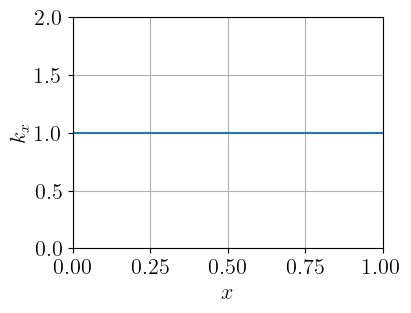

In [5]:
plt.figure(figsize=(4,3))
plt.plot(x, kx)
plt.xlim(0,1)
plt.ylim(0,2)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.grid()
plt.show()

## 2. Simple Inhomogeneous Plasma - Differentiation by Hand (O-mode)

**Method of Differentiation**

To solve the generic ray equations, I need to differentiate $D$. In my view this can be done through:
1. Automatic Differentiation (best option I think)
2. Differentiation by hand
2. Symbolic Differentiation
3. Finite Differences

In the following, the differentiation is done by hand.

We again consider the $O$-mode with
$$
D' = 1 - X - N^2 = 0
$$
Assume $X = n_e/n_c = x \, \theta(x) = \max(0,x)$ (where $x$ is the $x$-position-coordinate). This gives the ray equations
$$
d_t \vec{r} = c \vec{N}, \\
d_t \vec{N} = -\frac{c}{2} \theta(x) \hat{x}
$$

**Initial Conditions**

Initially we set $\vec{r}_0 = \vec{0}$. This gives $X_0 = 0$ which by $D(X=0)=0$ implies $N_0 = 1$.

This is for instance satisfied by:
$\vec{N}_0 = (1, 0, 0)$

In [108]:
# Initial condition
r0 = np.array([0,0,0])
N0 = np.array([1.0,0,0])
q0 = np.hstack((r0,N0))

# Set constants
c = 1

# Time interval of ODE solver
tmin = 0
tmax = 5

# RHS of ray-tracer ODE
def f(t, q):
    x, y, z, Nx, Ny, Nz = q
    r = np.array([x, y, z])
    N = np.array([Nx, Ny, Nz])
    RHS_r = c*N * np.heaviside(x + 0.05, 0)
    RHS_N = - (c/2) * np.heaviside(x, 0) * np.array([1, 0, 0])
    return np.hstack((RHS_r, RHS_N))

sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin,tmax, 100))
x, y, z, Nx, Ny, Nz = sol.y

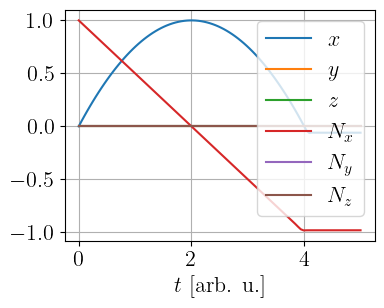

In [109]:
plt.figure(figsize=(4,3))
plt.plot(sol.t, sol.y.T)
plt.legend([r'$x$', r'$y$', r'$z$', r'$N_x$', r'$N_y$', r'$N_z$'])
plt.xlabel('$t$ [arb. u.]')
plt.grid()
plt.show()

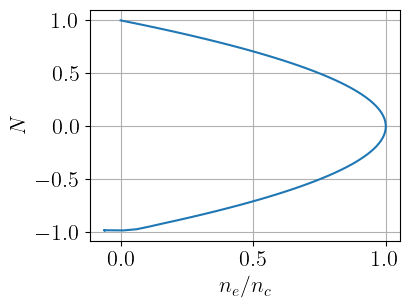

In [110]:
plt.figure(figsize=(4,3))
plt.plot(x, Nx)
# plt.xlim(0,1)
# plt.ylim(0,2)
plt.xlabel(r'$n_e/n_c$')
plt.ylabel(r'$N$')
plt.grid()
plt.show()

In [111]:
# Save solution for comparison with auto-grad method
x_hand = x
kx_hand = (omega/c) * Nx

## 3. Simple Inhomogeneous Plasma - Automatic Differentiation (O-mode)

We again consider the $O$-mode with
$$
D = 1 - X - N^2 = 0
$$
And as before, assume $X = n_e/n_c = x \, \theta(x) = \max(0,x)$.

I now work with the generic ray equations
$$
d_t \vec{r} = - \frac{\nabla_k D}{\partial D / \partial \omega}, \\[1em]
d_t \vec{k} = \frac{\nabla_r D}{\partial D / \partial \omega}
$$

In [123]:
# Note: Defining omega_p as in the following comments
# gives an undefined gradient when n_e = 0.
# Therefore we instead use omega_p_squared
# def omega_p(r):
#     return torch.sqrt(n_e(r) * e**2 / (eps_0 * m_e))
# def X(r, omega):
#     return omega_p(r)**2/(omega**2)

In [124]:
import torch

e = 1.0
eps_0 = 1.0
m_e = 1.0
c = 1.0

def n_e(r):
    x, y, z = r
    return x

def omega_p_squared(r):
    return n_e(r) * e**2 / (eps_0 * m_e)

def X(r, omega):
    return omega_p_squared(r)/(omega**2)

def N(k, omega):
    return c/omega * k

def D(r, k, omega):
    return 1 - X(r, omega) - torch.norm(N(k, omega))**2


### Test of Differentiation

We would expect
$$
\nabla_r D = -\frac{e^2}{\epsilon_0 m_e} \frac{1}{\omega^2} \hat{x} \\[1em]
\nabla_k D = - \frac{2 c^2}{\omega^2} \vec{k} \\[1em]
\frac{\partial D}{\partial \omega} = \frac{2}{\omega^3} \left( \frac{e^2 x}{\epsilon_0 m_e} + c^2 k^2 \right) = \frac{-2 (D-1)}{\omega}
$$

In [125]:
# Test of differentiation 1
omega0 = torch.tensor(1.0, requires_grad=True)
r0 = torch.tensor([0.0,0.0,0.0], requires_grad=True)
k0 = torch.tensor([torch.sqrt(omega0**2*(1-0.0)/c**2),0.0,0.0], requires_grad=True)

D0 = D(r0, k0, omega0)
D0.backward(retain_graph=True)

print('grad_r', r0.grad)
print('expected grad_r', -(e**2/eps_0 * m_e) * 1/omega0**2 * torch.tensor([1.0, 0.0, 0.0]))
print('grad_k', k0.grad)
print('expected grad_k', -2*c**2/omega0**2 * k0)
print('grad_omega', omega0.grad)
print('expected grad_omega', -2*(D0-1)/omega0)

grad_r tensor([-1.,  0.,  0.])
expected grad_r tensor([-1., -0., -0.], grad_fn=<MulBackward0>)
grad_k tensor([-2., -0., -0.])
expected grad_k tensor([-2., -0., -0.], grad_fn=<MulBackward0>)
grad_omega tensor(2.)
expected grad_omega tensor(2., grad_fn=<DivBackward0>)


In [126]:
# Test of differentiation 2
omega0 = torch.tensor(1.0, requires_grad=True)
r0 = torch.tensor([0.5,0.0,0.0], requires_grad=True)
k0 = torch.tensor([torch.sqrt(omega0**2*(1-0.5)/c**2),0.0,0.0], requires_grad=True)

D0 = D(r0, k0, omega0)
D0.backward(retain_graph=True)

print('grad_r', r0.grad)
print('expected grad_r', -(e**2/eps_0 * m_e) * 1/omega0**2 * torch.tensor([1.0, 0.0, 0.0]))
print('grad_k', k0.grad)
print('expected grad_k', -2*c**2/omega0**2 * k0)
print('grad_omega', omega0.grad)
print('expected grad_omega', -2*(D0-1)/omega0)

grad_r tensor([-1.,  0.,  0.])
expected grad_r tensor([-1., -0., -0.], grad_fn=<MulBackward0>)
grad_k tensor([-1.4142, -0.0000, -0.0000])
expected grad_k tensor([-1.4142, -0.0000, -0.0000], grad_fn=<MulBackward0>)
grad_omega tensor(2.)
expected grad_omega tensor(2., grad_fn=<DivBackward0>)


### Ray Tracer

In [215]:
def trace_ray(r0, k0, omega0, tmin, tmax, D):
    q0 = np.hstack((r0,k0))

    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)

        Di = D(r, k, omega)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        grad_omega = omega.grad
        RHS_r = - grad_k/grad_omega
        RHS_k = grad_r/grad_omega
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin,tmax, 100))
    return sol

#### Ray in x-direction

In [216]:
# Ray in x-direction
x0 = 0
omega0 = np.array(1.0)
r0 = np.array([x0,1.0,1.0])
k0 = np.array([np.sqrt(omega0**2*(1-x0)/c**2),0.0,0.0])
print('omega0', omega0)
print('r0', r0)
print('k0', k0)

sol = trace_ray(r0, k0, omega0, tmin=0, tmax=5, D=D)
x, y, z, kx, ky, kz = sol.y

omega0 1.0
r0 [0. 1. 1.]
k0 [1. 0. 0.]


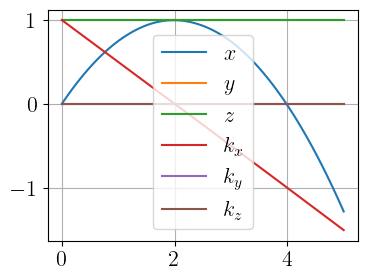

In [217]:
plt.figure(figsize=(4,3))
plt.plot(sol.t, sol.y.T)
plt.legend([r'$x$', r'$y$', r'$z$', r'$k_x$', r'$k_y$', r'$k_z$'])
plt.grid()
plt.show()

/var/folders/r5/t43xdldn22j7t9y2_n0kl3x00000gp/T/ipykernel_22225/763639144.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x, np.sqrt(1-np.abs(x)), color='tab:red', label='exact')


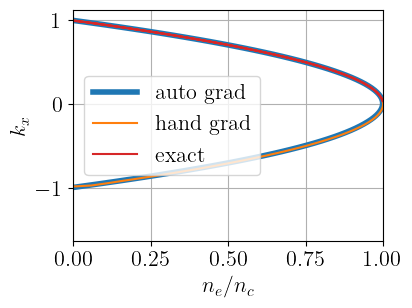

In [218]:
plt.figure(figsize=(4,3))
plt.plot(x, kx, color='tab:blue', linewidth=4, label='auto grad')
plt.plot(x_hand, kx_hand, color='tab:orange', label='hand grad')
plt.plot(x, np.sqrt(1-np.abs(x)), color='tab:red', label='exact')
plt.legend()
plt.xlim(0,1)
# plt.ylim(0,2)
plt.xlabel(r'$n_e/n_c$')
plt.ylabel(r'$k_x$')
plt.grid()
plt.show()

#### Ray at an angle

In [219]:
# Ray at an angle
x0 = 0
omega0 = np.array(1.0)
r0 = np.array([x0,1.0,1.0])
k_dir = np.array([1.0,2.0,0.0])
k_hat = k_dir/np.linalg.norm(k_dir)
k0 = (omega0/c) * (np.sqrt(1-X(r0,omega0)**2))*k_hat
print('omega0', omega0)
print('r0', r0)
print('k0', k0)

sol = trace_ray(r0, k0, omega0, tmin=0, tmax=5, D=D)
x, y, z, kx, ky, kz = sol.y

omega0 1.0
r0 [0. 1. 1.]
k0 [0.4472136  0.89442719 0.        ]


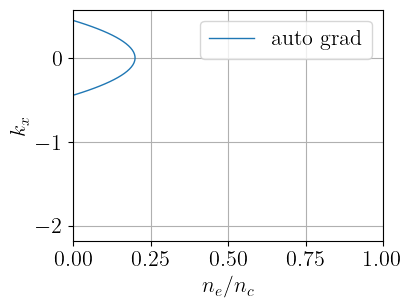

In [220]:
plt.figure(figsize=(4,3))
plt.plot(x, kx, color='tab:blue', linewidth=1, label='auto grad')
plt.legend()
plt.xlim(0,1)
# plt.ylim(0,2)
plt.xlabel(r'$n_e/n_c$')
plt.ylabel(r'$k_x$')
plt.grid()
plt.show()

### Ray Tracer with Boundary Conditions

We can extend the ray tracer with a simple boundary condition check.

The user sets $r_\text{min} = (x_\text{min}, y_\text{min}, z_\text{min})$ and $r_\text{max} = (x_\text{min}, y_\text{max}, z_\text{max})$.

The ray is assumed to stop, when it hits these boundaries.

This is done by multiplying the rhs of the ray equations with the following function:
```python
def is_in_domain(r):
    ''' Returns 0.0 if ray exceeds boundary'''
    return torch.prod(torch.heaviside(r-r_min, torch.ones_like(r)))*torch.prod(torch.heaviside(r_max-r, torch.ones_like(r)))
```

In [221]:
def trace_ray(r0, k0, omega0, tmin, tmax, D, r_min=torch.tensor([0, 0, 0]), r_max=torch.tensor([1000,1000,1000])):
    q0 = np.hstack((r0,k0))
    
    def is_in_domain(r):
        ''' Returns 0.0 if ray exceeds boundary'''
        return torch.prod(torch.heaviside(r-r_min, torch.ones_like(r)))*torch.prod(torch.heaviside(r_max-r, torch.ones_like(r)))
    
    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)
        
        Di = D(r, k, omega)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        grad_omega = omega.grad
        RHS_r = - grad_k/grad_omega * is_in_domain(r)
        RHS_k = grad_r/grad_omega * is_in_domain(r)
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin,tmax, 100))
    return sol

omega0 1.0
r0 [0. 1. 1.]
k0 [1. 0. 0.]


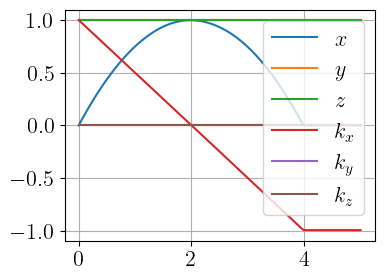

In [222]:
# Ray in x-direction
x0 = 0
omega0 = np.array(1.0)
r0 = np.array([x0,1.0,1.0])
k0 = np.array([np.sqrt(omega0**2*(1-x0)/c**2),0.0,0.0])
print('omega0', omega0)
print('r0', r0)
print('k0', k0)

sol = trace_ray(r0, k0, omega0, tmin=0, tmax=5, D=D)
x, y, z, kx, ky, kz = sol.y

plt.figure(figsize=(4,3))
plt.plot(sol.t, sol.y.T)
plt.legend([r'$x$', r'$y$', r'$z$', r'$k_x$', r'$k_y$', r'$k_z$'])
plt.grid()
plt.show()